# Regression Modelling

Preprocess Data & Run Regression Algorithms to determine the importance / success of different offer types for different customer segments.


### Data Sources

Cleaned datafiles, as prepared in notebook 1: `profile_type_clean.csv`: demographic data and KPI for each of the offer types per customer.

### Changes

- 2019-01-22: Started notebook



In [1]:
# load libraries

import numpy as np
import pandas as pd
from tqdm import tqdm

# my own custom functions
import EDA_functions as EDA
import cleaning_functions as cleaning
from linRegModel_class import LinRegModel 

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import resample  # for error calculation of feature weights

# visualization
import matplotlib.pyplot as plt
import seaborn as sns #, sns.set_style('whitegrid')
color = 'rebeccapurple'
%matplotlib inline

# display settings
from IPython.display import display
pd.options.display.max_columns = None

from pathlib import Path  # to make file path references relative to notebook directory

In [2]:
# import preparated data

profile_type_file = Path.cwd() / "data" / "processed" / "profile_type_clean.csv"
profile_type = pd.read_csv(profile_type_file, index_col = 0, dtype={'gender' : 'category'})

## Check profile type data

In [3]:
display(profile_type.head())
display(profile_type.info())

,age,gender,income,member_days,offer_received,offer_viewed,offer_completed,viewed_received,completed_viewed,total_trans,total_amount,total_reward,total_profit,prop_reward,total_mean_amount,np_trans,np_amount,np_mean_amount,prop_np_trans,prop_np_amount,bogo_completed,bogo_viewed,bogo_trans,bogo_amount,discount_completed,discount_viewed,discount_trans,discount_amount,info_viewed,info_trans,info_amount
p_1,NaN,NaN,NaN,-529,5.0,5.0,2.0,1.00,2.0,9.0,20.40,5.0,15.40,0.245098,2.266667,0,0.00,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000,2.0,5.0,9.0,20.400,0.0,0.0,0.000
p_10,NaN,NaN,NaN,-611,4.0,3.0,1.0,0.75,0.0,6.0,15.62,5.0,10.62,0.320102,2.603333,3,7.69,2.563333,0.500000,0.492318,0.0,2.0,3.0,7.930,0.0,0.0,0.0,0.000,1.0,0.0,0.000
p_100,68.0,F,84000.0,-725,5.0,0.0,1.0,0.00,0.0,2.0,34.04,2.0,32.04,0.058754,17.020000,2,34.04,17.020000,1.000000,1.000000,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0,0.000
p_1000,67.0,M,44000.0,-225,4.0,4.0,0.0,1.00,0.0,5.0,19.78,0.0,19.78,0.000000,3.956000,2,13.37,6.685000,0.400000,0.675935,0.0,3.0,3.0,5.555,0.0,0.0,0.0,0.000,1.0,1.0,0.855
p_10000,NaN,NaN,NaN,-446,3.0,3.0,0.0,1.00,0.0,6.0,7.28,0.0,7.28,0.000000,1.213333,1,1.83,1.830000,0.166667,0.251374,0.0,2.0,4.0,3.935,0.0,1.0,3.0,1.515,0.0,0.0,0.000


<class 'pandas.core.frame.DataFrame'>
Index: 17000 entries, p_1 to p_9999
Data columns (total 31 columns):
age                   14825 non-null float64
gender                14825 non-null category
income                14825 non-null float64
member_days           17000 non-null int64
offer_received        17000 non-null float64
offer_viewed          17000 non-null float64
offer_completed       17000 non-null float64
viewed_received       17000 non-null float64
completed_viewed      17000 non-null float64
total_trans           17000 non-null float64
total_amount          17000 non-null float64
total_reward          17000 non-null float64
total_profit          17000 non-null float64
prop_reward           17000 non-null float64
total_mean_amount     17000 non-null float64
np_trans              17000 non-null int64
np_amount             17000 non-null float64
np_mean_amount        17000 non-null float64
prop_np_trans         17000 non-null float64
prop_np_amount        17000 non-null floa

None

In [4]:
# """eliminiate missing values"""

# profile = cleaning.handle_NaN(profile, cols_to_impute_num=['age', 'income'])
# profile['gender'] = profile['gender'].fillna('u')

In [5]:
# check results
# profile.head()

### Select relevant columns for modelling

In [7]:
"""calculate some additional ratios"""

profile_type['prop_bogo_amount'] = profile_type['bogo_amount'] / profile_type['total_amount']
profile_type['prop_discount_amount'] = profile_type['discount_amount'] / profile_type['total_amount']
profile_type['prop_info_amount'] = profile_type['info_amount'] / profile_type['total_amount']

profile_type['bogo_vtc'] = profile_type['bogo_completed'] / profile_type['bogo_viewed']
profile_type['discount_vtc'] = profile_type['discount_completed'] / profile_type['discount_viewed']

profile_type['complete_by_accident'] = profile_type['offer_completed'] - profile_type['completed_viewed']

# eliminate NaN in aggregated data and check results
profile_type.iloc[: , 4:] = profile_type.iloc[: , 4:].fillna(value=0.0)
display(profile_type.head(2))

,age,gender,income,member_days,offer_received,offer_viewed,offer_completed,viewed_received,completed_viewed,total_trans,total_amount,total_reward,total_profit,prop_reward,total_mean_amount,np_trans,np_amount,np_mean_amount,prop_np_trans,prop_np_amount,bogo_completed,bogo_viewed,bogo_trans,bogo_amount,discount_completed,discount_viewed,discount_trans,discount_amount,info_viewed,info_trans,info_amount,prop_bogo_amount,prop_discount_amount,prop_info_amount,bogo_vtc,discount_vtc,complete_by_accident
p_1,NaN,NaN,NaN,-529,5.0,5.0,2.0,1.00,2.0,9.0,20.40,5.0,15.40,0.245098,2.266667,0,0.00,0.000000,0.0,0.000000,0.0,0.0,0.0,0.00,2.0,5.0,9.0,20.4,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.4,0.0
p_10,NaN,NaN,NaN,-611,4.0,3.0,1.0,0.75,0.0,6.0,15.62,5.0,10.62,0.320102,2.603333,3,7.69,2.563333,0.5,0.492318,0.0,2.0,3.0,7.93,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.507682,0.0,0.0,0.0,0.0,1.0


In [16]:
profile = profile_type[['age', 'gender', 'income', 'member_days', 'viewed_received', 'total_trans', 'prop_np_amount', 'bogo_completed', 'bogo_viewed', 
                        'prop_bogo_amount', 'discount_completed', 'discount_viewed', 'prop_discount_amount', 'info_viewed', 
                       'prop_info_amount', 'complete_by_accident', 'total_profit']]

## Run quick and dirty linear regression

In [17]:
"initialize and run base model"

# define a scikit-learn model object you want to work with
model = LinearRegression(normalize=True)
# create an instance of the LinRegModel class by passing the dataframe, the target variable and the model object
linReg_simple = LinRegModel(profile, 'total_profit', model)
# go
linReg_simple.go_quickDirty()

C:\Users\r2d4\Anaconda3\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [18]:
# check performance
linReg_simple

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

RMSE on test data 95.26, r2-score 0.40.

[learning_curve] Training set sizes: [  95  591 1087 1583 2079 2575 3071 3567 4063 4559 5055 5551 6047 6543
 7039 7535 8031 8527 9023 9520]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.6s finished


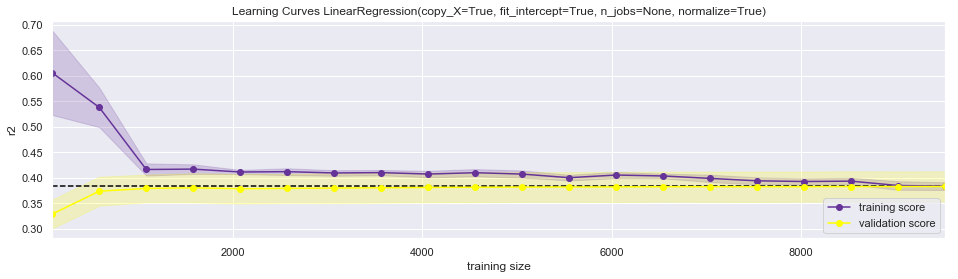

In [33]:
"""plot learning curves using 5-fold cross validation"""
linReg_simple.plot_learning_curves()

### Check results for Ridge, Lasso, ElasticNet

In [19]:
# define RidgeCV without normalization but higher alphas)
model = RidgeCV(alphas=[30, 50, 70], cv=3, fit_intercept=True)
# instantiate
ridgeCV_simple = LinRegModel(profile, 'total_profit', model)
# perform linear regression modelling
ridgeCV_simple.go_quickDirty()
# output scores
ridgeCV_simple

C:\Users\r2d4\Anaconda3\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


RidgeCV(alphas=array([30, 50, 70]), cv=3, fit_intercept=True, gcv_mode=None,
    normalize=False, scoring=None, store_cv_values=False)

RMSE on test data 95.27, r2-score 0.40.

In [35]:
model.alpha_

30

In [36]:
# plot feature weights
# ridgeCV_simple.print_coef_weights(n_bootstrap=10)

In [38]:
# define lassoCV without normalization (but higher alphas)
model = LassoCV(alphas=[0.01, 0.1, 1],cv=3, fit_intercept=True)
# instantiate
lassoCV_simple = LinRegModel(profile, 'total_profit', model)
# perform linear regression modelling
lassoCV_simple.go_quickDirty()
# output scores
lassoCV_simple

C:\Users\r2d4\Anaconda3\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


LassoCV(alphas=[0.01, 0.1, 1], copy_X=True, cv=3, eps=0.001,
    fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=None,
    normalize=False, positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

RMSE on test data 97.06, r2-score 0.37.

In [39]:
model.alpha_

0.01

In [40]:
# plot feature weights
lassoCV_simple.print_coef_weights(n_bootstrap=10)

,effect,error
prop_np_amount,59.1,0.0
gender_nan,-51.9,0.0
bogo_completed,29.2,0.0
viewed_received,21.4,5.0
discount_completed,15.1,0.0
gender_M,-9.9,5.0
total_trans,7.8,1.0
info_viewed,7.3,1.0
gender_O,-7.2,1.0
bogo_viewed,-6.9,1.0


In [21]:
# define ElasticNetCV without normalization
model = ElasticNetCV(alphas=[0.05, 0.1, 0.2], copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.2, 0.5, 0.7], max_iter=1000, n_alphas=None, n_jobs=-1)
# instantiate
elasticNetCV_simple = LinRegModel(profile, 'total_profit', model)
# perform linear regression modelling on instance
elasticNetCV_simple.go_quickDirty()
# output scores
elasticNetCV_simple

C:\Users\r2d4\Anaconda3\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


ElasticNetCV(alphas=[0.05, 0.1, 0.2], copy_X=True, cv=5, eps=0.001,
       fit_intercept=True, l1_ratio=[0.2, 0.5, 0.7], max_iter=1000,
       n_alphas=None, n_jobs=-1, normalize=False, positive=False,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0)

RMSE on test data 95.39, r2-score 0.39.

In [16]:
print(model.alpha_)
print(model.l1_ratio_)

0.05
0.7


In [17]:
# plot feature weights
# elasticNetCV_simple.print_coef_weights(n_bootstrap=10)

## Second approach with proper data preparation

In [22]:
"""eliminate outliers"""

# count outliers
cleaning.count_outliers_IQR_method(profile, IQR_dist=1.5)

age
Identified outliers: 48
Percentage of outliers: 0.3%

income
Identified outliers: 306
Percentage of outliers: 1.8%

member_days
Identified outliers: 287
Percentage of outliers: 1.7%

viewed_received
Identified outliers: 0
Percentage of outliers: 0.0%

total_trans
Identified outliers: 296
Percentage of outliers: 1.7%

prop_np_amount
Identified outliers: 0
Percentage of outliers: 0.0%

bogo_completed
Identified outliers: 667
Percentage of outliers: 3.9%

bogo_viewed
Identified outliers: 632
Percentage of outliers: 3.7%

prop_bogo_amount
Identified outliers: 389
Percentage of outliers: 2.3%

discount_completed
Identified outliers: 743
Percentage of outliers: 4.4%

discount_viewed
Identified outliers: 2
Percentage of outliers: 0.0%

prop_discount_amount
Identified outliers: 498
Percentage of outliers: 2.9%

info_viewed
Identified outliers: 286
Percentage of outliers: 1.7%

prop_info_amount
Identified outliers: 2988
Percentage of outliers: 17.6%

complete_by_accident
Identified outliers

In [23]:
# remove oultiers
outlier_cols = ['total_profit']
cleaning.remove_outliers_IQR_method(profile, outlier_cols=outlier_cols, IQR_dist=1.5)

total_profit


C:\Users\r2d4\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Rows removed: 606


Rows removed in total: 606



In [25]:
# instantiate
elasticNetCV_simple = LinRegModel(profile, 'total_profit', model)
# perform linear regression modelling on instance
elasticNetCV_simple.go_quickDirty()
# output scores
elasticNetCV_simple

C:\Users\r2d4\Anaconda3\lib\site-packages\pandas\core\generic.py:5434: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


ElasticNetCV(alphas=[0.05, 0.1, 0.2], copy_X=True, cv=5, eps=0.001,
       fit_intercept=True, l1_ratio=[0.2, 0.5, 0.7], max_iter=1000,
       n_alphas=None, n_jobs=-1, normalize=False, positive=False,
       precompute='auto', random_state=None, selection='cyclic',
       tol=0.0001, verbose=0)

RMSE on test data 39.69, r2-score 0.69.

In [26]:
print(model.alpha_)
print(model.l1_ratio_)

0.05
0.7


In [46]:
elasticNetCV_simple.print_coef_weights(n_bootstrap=10)

,effect,error
prop_np_amount,48.8,0.0
gender_nan,-45.0,0.0
viewed_received,23.3,0.0
bogo_completed,23.0,2.0
discount_completed,12.2,0.0
gender_M,-9.9,1.0
bogo_viewed,-6.5,1.0
total_trans,6.1,1.0
info_viewed,5.5,1.0
gender_O,-1.6,1.0


[learning_curve] Training set sizes: [  91  570 1048 1526 2005 2483 2961 3440 3918 4396 4875 5353 5831 6310
 6788 7266 7745 8223 8701 9180]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.4s finished


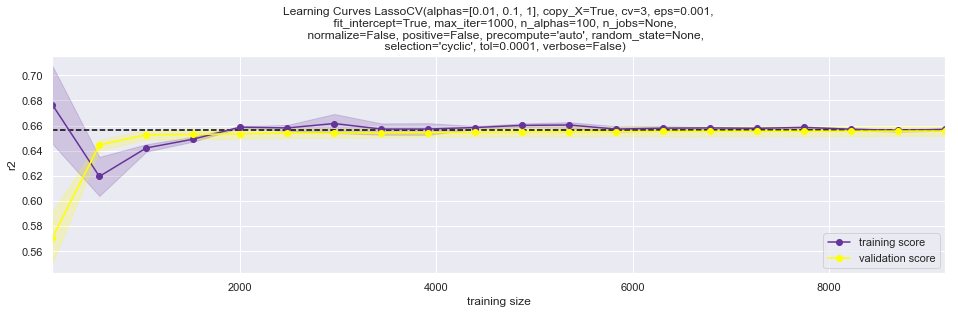

In [47]:
"""plot learning curves using 5-fold cross validation"""
elasticNetCV_simple.plot_learning_curves()

In [38]:
"""log transform"""

# cleaning.apply_log10(profile, cols_to_log10=['member_days'])

In [39]:
# # define ElasticNetCV without normalization
# model = ElasticNetCV(alphas=[0.05], copy_X=True, cv=5, eps=0.001, fit_intercept=True,
#        l1_ratio=[0.2, 0.5, 0.7], max_iter=1000, n_alphas=None, n_jobs=-1)

# # instantiate
# elasticNetCV_simple = LinRegModel(profile, 'total_amount_log', model)
# # perform linear regression modelling on instance
# elasticNetCV_simple.go_quickDirty()
# # output scores
# elasticNetCV_simple

ElasticNetCV(alphas=[0.05], copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.2, 0.5, 0.7], max_iter=1000, n_alphas=None, n_jobs=-1,
       normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)

RMSE on test data 0.34, r2-score 0.65.

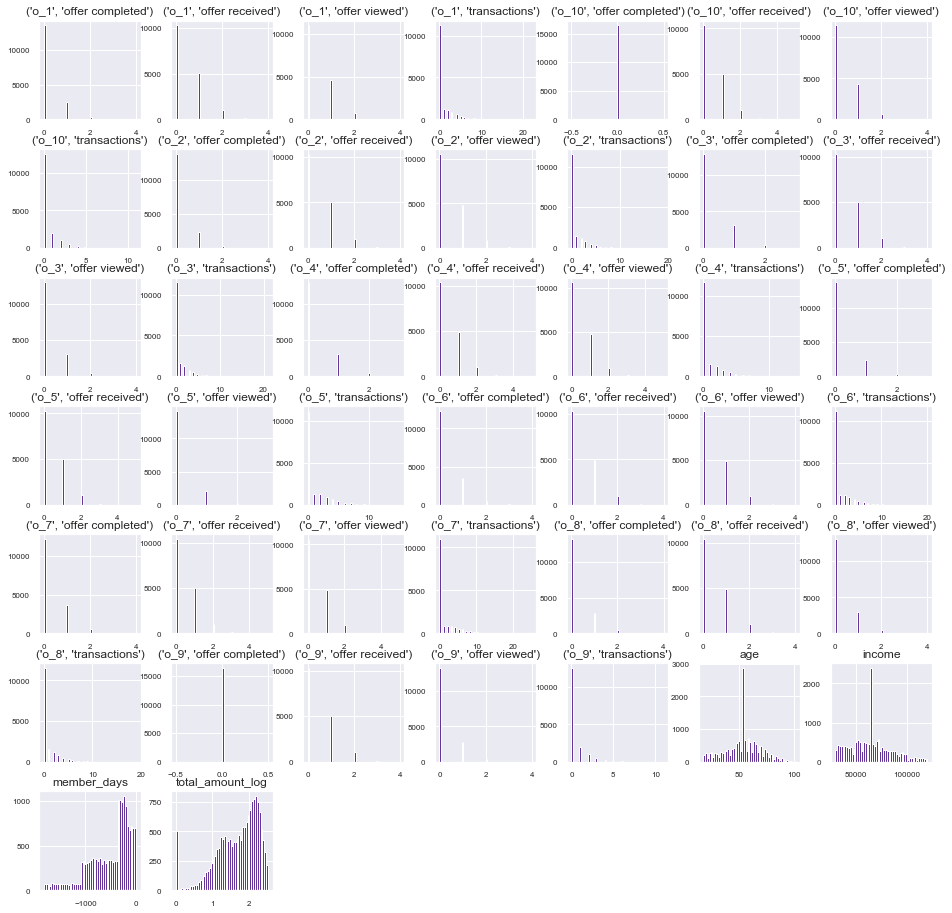

In [37]:
# check results
EDA.plot_num_hist(profile)